# ${\textbf{1 Durchführung und Auswertung}}$

Um größtmögliche Transparenz bei der Auswertung des Versuchs zu gewährleisten, wird die gesamte Datenanalyse in diesem Jupyter Notebook niedergeschrieben.
Die Versuchsvorbereitung ist in einer separaten Datei zu finden.

Hinweis: Es wird empfohlen, stets alle Codeblöcke hintereinander in der vorliegenden Reihenfolge auszuführen! ($\rightarrow$ Run $\rightarrow$ Run All Cells)

## $\textbf{1.1 Inhaltsverzeichnis}$ <a class="anchor" id="chapter1"></a>

* [$\textrm{1.1 Inhaltsverzeichnis}$](#chapter1)
* [$\textrm{1.2 Bestimmung der Rauschschwelle der Detektoren}$](#chapter2)
* [$\textrm{1.3 Aufnahme eines Pulshöhenspektrums}$](#chapter3)
* [$\textrm{1.4 Bestimmung der Effizienzen der einzelnen Detektormodule}$](#chapter4)
* [$\textrm{1.5 Bestimmung der Lebensdauer des Myons}$](#chapter5)
* [$\textrm{1.6 Nachweis der Präzession des Myonenspins im Magnetfeld}$](#chapter6)

## $\textbf{1.2 Bestimmung der Rauschschwelle der Detektoren}$ <a class="anchor" id="chapter2"></a>

Bevor die Messungen zu den Eigenschaften des Myons beginnen können, muss die Versuchstechnik geeignet konfiguriert werden. In diesem Zusammenhang wird zunächst die Rausschwelle der Detektoren bestimmt.
In der „PicoScope 6”-Software werden verschiedene Triggerschwellen angesetzt und graphisch evaluiert. Um möglichst viele echte Myonen aufzunehmen und gleichzeitig aber das Untergrundrauschen zu unterdrücken, wird die Arbeitsschwelle hoch genug angesetzt, um das Eigenrauschen der Detektormodule zu filtern. Allerdings muss die Schwelle noch niedrig genug liegen, um die beobachtbaren Signalspitzen, für deren Ursprung Elektronen/ Positronen und kosmische Myonen in Frage kommen, aufzunehmen. Die PicoScope Software erlaubt es, die Schwelle per Maus zu verschieben und liefert sofort graphisches Feedback, sodass das Finden einer geeigneten Schwelle relativ anschaulich möglich ist. Der gefundene Schwellenwert ($\geq 30$ mV oberhalb vom DC-Offset) wird anschließend in eine Konfigurationsdatei, die im .yaml-Format vorliegt, eingetragen und für die folgenden Messungen als Triggerbedingung berücksichtigt.

## $\textbf{1.3 Aufnahme eines Pulshöhensprektrums}$ <a class="anchor" id="chapter3"></a>

Nun wird eine Analyse des Pulshöhenspektrums durchgeführt. Ziel ist es, die Pulshöhen der einzelnen Module zu kalibrieren und erneut geeignete Schnitte für die Energien zu finden. Dafür wird in einem ersten Schritt eine 10-minütige Messung der Pulshöhenspektren vorgenommen. Zunächst werden nur diejenigen Events betrachtet, die in den Panels A, B und C simultan nachgewiesen werden. Bei diesen Dreifach-Koinzidenzen handelt es sich mit sehr hoher Wahrscheinlichkeit um echte Myonen.

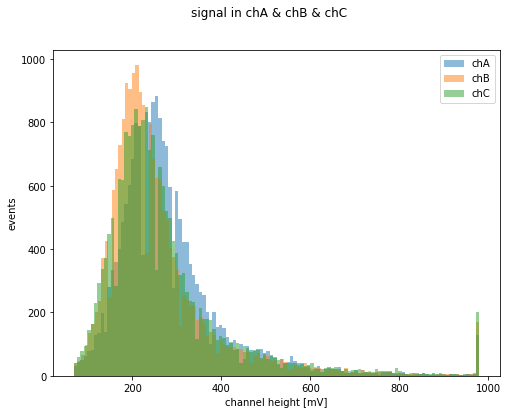

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PhyPraKit.phyFit import mFit, hFit #requires iminuit
import pandas as pd
import scipy.constants as const
import scipy.stats as st

# > Read in data from measurement

measurements = ['spectrum/spectrum_2021-10-21_154946.csv']

spectrum = pd.read_csv(measurements[0], sep="\t")

# > Cut for coincidences in chA, chB and chC

mask_ABC= (spectrum['chA height'] > 0) & (spectrum['chB height'] > 0) & (spectrum['chC height'] > 0)

spectrum_ABC = spectrum[mask_ABC] # apply the cut

# > Plot the results

plt.subplots(figsize=(8,6))
plt.hist(spectrum_ABC['chA height'],alpha = 0.5, bins= 120, label = 'chA')
plt.hist(spectrum_ABC['chB height'],alpha = 0.5, bins= 120, label = 'chB')
plt.hist(spectrum_ABC['chC height'],alpha = 0.5, bins= 120, label = 'chC')
plt.xlabel('channel height [mV]')
plt.ylabel('events')
plt.legend()
plt.suptitle('signal in chA & chB & chC')
plt.show()

Diese „durchschlagenden”  Myonen eignen sich besonders gut dafür, die Pulshöhen zu kalibrieren, da davon auszugehen ist, dass sie in jedem Szintillatorpanel im Mittel etwa gleich viel Energie abgeben. Entsprechend müssten die Pulshöhenverteilungen der drei Panel im kalibrierten Zustand gut übereinanderliegen. Im oberen Plot ist zu sehen, dass sie derzeit noch leicht voneinander verschoben sind. Zur Kalibrierung muss ein geeigneter Schätzwert für die einzelnen Panels bestimmt werden. Um Ausreißer zu ignorieren, werden die obersten und untersten 10%-Quantile der Pulshöhenverteilungen geschnitten und anschließend die Mittelwerte der verbleibenden Pulshöhen gebildet („truncated mean”). Mit den hieraus bestimmten Werten lassen sich die Verteilungen aneinander angleichen.

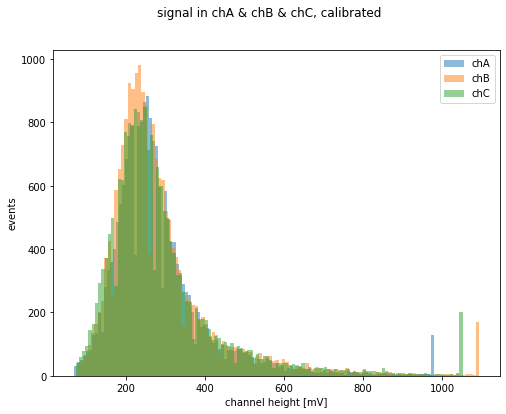

In [2]:
# > Calculate the truncated mean

chA_truncated = spectrum_ABC[(spectrum_ABC['chA height'] > spectrum_ABC.quantile(0.1)['chA height']) & (spectrum_ABC['chA height'] < spectrum_ABC.quantile(0.9)['chA height'])] # truncate the data
chA_tm = chA_truncated['chA height'].mean() # calculate the mean pulse height of the remaining data

chB_truncated = spectrum_ABC[(spectrum_ABC['chB height'] > spectrum_ABC.quantile(0.1)['chB height']) & (spectrum_ABC['chB height'] < spectrum_ABC.quantile(0.9)['chB height'])]
chB_tm = chB_truncated['chB height'].mean()

chC_truncated = spectrum_ABC[(spectrum_ABC['chC height'] > spectrum_ABC.quantile(0.1)['chC height']) & (spectrum_ABC['chC height'] < spectrum_ABC.quantile(0.9)['chC height'])]
chC_tm = chC_truncated['chC height'].mean()

# > Calculate & apply the calibration factors

chA_factor = 1
chB_factor = chA_tm/chB_tm
chC_factor = chA_tm/chC_tm

chA_ABC_calibrated = chA_factor * spectrum_ABC['chA height']
chB_ABC_calibrated = chB_factor * spectrum_ABC['chB height']
chC_ABC_calibrated = chC_factor * spectrum_ABC['chC height']

# > Plot the results

plt.subplots(figsize=(8,6))
plt.hist(chA_ABC_calibrated,alpha = 0.5, bins= 120, label = 'chA')
plt.hist(chB_ABC_calibrated,alpha = 0.5, bins= 120, label = 'chB')
plt.hist(chC_ABC_calibrated,alpha = 0.5, bins= 120, label = 'chC')
plt.xlabel('channel height [mV]')
plt.ylabel('events')
plt.legend()
plt.suptitle('signal in chA & chB & chC, calibrated')
plt.show()

Mit Hilfe der kalibrierten Verteilung kann nun eine geeignete untere Grenze für die Myonenpeaks gewählt werden. Es macht Sinn, die Schwelle niedrig anzusetzen, um möglichst viele Myonendurchgänge aufzunehmen. Eine Schwelle von 70 mV wird entsprechend gesetzt. Dieser Wert wird in die Konfigurationsdateien der Lebensdauer- und der Landé-Messung eingetragen und nachfolgend ebenfalls als Triggerbedingung berücksichtigt. Bei Bedarf können auch höhere Schwellen später in der Datenauswertung ausprobiert werden. Die untere Grenze für die verzögerten Pulse, für deren Ursprung Elektronen/ Positronen in Frage kommen, sollte sinnvollerweise auf die Triggerschwelle für den Untergrund gesetzt werden. Der Wert 30 mV wird entsprechend gewählt. Auch hier können strengere Anforderungen im Nachhinein bei der Analyse gefordert werden, wobei zwischen „purity” und „efficiency” des Signals abgewogen werden muss.

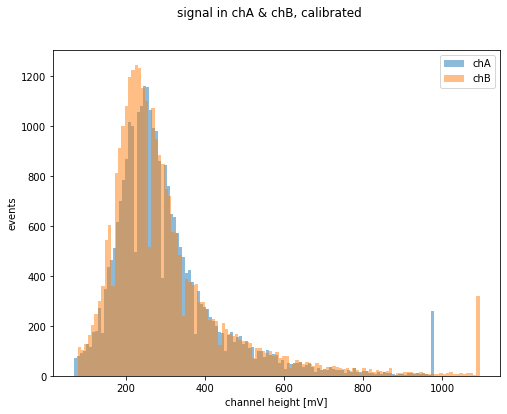

In [3]:
# > Cut for coincidences in chA and chB

mask_ABc = (spectrum['chA height'] > 0) & (spectrum['chB height'] > 0)
spectrum_ABc = spectrum[mask_ABc] # apply the cut

# > Apply the calibration factors

chA_ABc_calibrated = chA_factor * spectrum_ABc['chA height']
chB_ABc_calibrated = chB_factor * spectrum_ABc['chB height']

# > Plot the results

plt.subplots(figsize=(8,6))
plt.hist(chA_ABc_calibrated,alpha = 0.5, bins= 120, label = 'chA')
plt.hist(chB_ABc_calibrated,alpha = 0.5, bins= 120, label = 'chB')
plt.xlabel('channel height [mV]')
plt.ylabel('events')
plt.legend()
plt.suptitle('signal in chA & chB, calibrated')
plt.show()

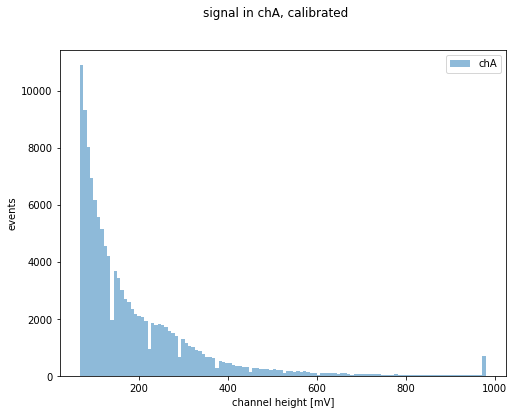

In [4]:
# > Plotting all the signals that caused a trigger in chA

chA_Abc_calibrated = chA_factor * spectrum['chA height']

plt.subplots(figsize=(8,6))
plt.hist(chA_Abc_calibrated,alpha = 0.5, bins= 120, label = 'chA')
plt.xlabel('channel height [mV]')
plt.ylabel('events')
plt.legend()
plt.suptitle('signal in chA, calibrated')
plt.show()

Auf diesem Histogramm ist vornehmlich das thermische Rauschen des SiPM zu erkennen, welches zwar relativ schnell mit der Pulshöhe abnimmt, aber dennoch deutlich mit den Myonensignalen überlappt. Das thermische Rauschen in den drei Panels ist nicht korreliert, sodass diese Rauschpulse durch Forderung von zeitlicher Koinzidenz der Signale relativ leicht zu filtern sind. Es wird ersichtlich, dass bereits die Forderung von Koinzidenz in zwei Panels einen überwiegenden Teil des Rauschens filtert. Diese Erkenntnis ist insbesondere für den nächsten Abschnitt wichtig, wo es um die Effizienzbestimmung der Detektormodule mit dem „tag and probe”-Verfahren geht. Es sollte zuletzt noch darauf hingewiesen werden, dass sich aus diesen Pulshöhenverteilungen noch nicht ableiten lässt, wie viel Energie die Teilchen in den Szintillatorpanels verlieren. Dafür wären noch Referenzmessungen mit anderen Teilchenquellen erforderlich. Insofern werden hier zunächst nur relative Energieskalen betrachtet.

## $\textbf{1.4 Bestimmung der Effizienzen der einzelnen Detektormodule}$ <a class="anchor" id="chapter4"></a>

In diesem Abschnitt werden die Effizienzen der einzelnen Detektormodule bestimmt. Die Effizienz eines Detekors ist definiert als das Verhältnis von detektierten Teilcheneinfällen zur Gesamtzahl der Teilcheneinfälle. Zur Effizienzbestimmung kommt hier das sogenannte „tag and probe“-Verfahren zur Anwendung. Dieses soll hier exemplarisch zur Bestimmung der Effizienz von Panel B diskutiert werden.

* Die probe-Teilchen definieren einen sinnvollen Begriff für eine Gesamtzahl der Teilcheneinfälle durch Panel B. Als probe-Teilchen werden diejenigen Teilchen bezeichnet, welche simultan in den Detektoren A und D nachgewiesen werden. Da die Detektoren übereinander angeordnet sind, kann hier also mit großer Wahrscheinlichkeit von einem echten Myonendurchgang durch Panel B ausgegangen werden, da sich dieses zwischen den Detektoren A und D befindet.

* Die tag-Teilchen sind diejenigen probe-Teilchen, welche zusätzlich noch in Panel B nachgewiesen werden.

Die Effizienz von Panel B ist dann gegeben durch $\epsilon_\textrm{B} = \frac{N_\textrm{tag}}{N_\textrm{probe}}$. Ein ähnliches Verfahren kann zur Bestimmung der Effizienz von Panel C durchgeführt werden. Zuletzt soll noch die Effizienz von Panel A bestimmt werden. An dieser Stelle muss der Versuchsaufbau ein wenig modifiziert werden, da sich oberhalb von Panel A standardmäßig kein weiteres Panel mehr befindet. Hierfür werden die CosmoPanels vom Netzwerk Teilchenwelt verwendet, wobei jeweils ein CosmoPanel oberhalb und eines unterhalb von Panel A aufgebaut wird. Mit dieser Anordnung kann auch die Effizienz von Panel A vollkommen analog bestimmt werden. An dieser Stelle sollte darauf hingewiesen werden, dass die hierdurch bestimmte Effizienz für Panel A nicht direkt mit den Effizienzen der Panel B und C verglichen werden kann, da es sich bei den CosmoPanels nicht um baugleiche Detektoren handelt. Da die CosmoPanels z.B. ein stärkeres Detektorrauschen aufweisen, muss die Untergrundschwelle bei der Messung entsprechend hoch gesetzt werden. Deshalb werden Myonen, die niedrige Pulse erzeugen, seltener "getaggt". Da diese niedrigen Pulse aber auch tendenziell schwieriger zu detektieren sind, wird die Effizienz von Panel A im direkten Vergleich zu hoch eingeschätzt. Auch Geometrieeffekte könnten zusätzlich zu dieser Diskrepanz beitragen. Aufgrund der Größe der CosmoPanels kann außerdem nur die Effizienz für ein kleines Areal des Detektors bestimmt werden. Es wären also mehrere Messungen notwendig, um die ganze Detektorfläche abzudecken.

Unter der Annahme, dass es sich bei dem Messprozess um einen Binomialprozess handelt ($n_\textrm{tag}$ „Treffer“ bei $n_\textrm{probe}$ „Versuchen“ mit der wahren Effizienz $\hat\epsilon$ als Trefferwahrscheinlichkeit), ergibt sich durch einfache Fehlerfortpflanzung der folgende statistische Fehler $\sigma_\epsilon$ auf die gemessene Effizienz $\epsilon$:

$$
\sigma_\epsilon = \sqrt{\frac{\epsilon \cdot (1 - \epsilon)}{n_\textrm{probe}}}
$$

Es werden die folgenden Effizienzen bestimmt:

* $\epsilon_\textrm{A} = (98.48 ± 0.75) \%$

* $\epsilon_\textrm{B} = (96.72 ± 0.15) \%$

* $\epsilon_\textrm{C} = (96.56 ± 0.15) \%$

Die Effizienzen der drei Panels liegen im erwarteten Bereich $\left(\epsilon \geq 95\%\right)$. Der statistische Fehler auf die Effizienz von Panel A ist erwartungsgemäß größer, da die CosmoPanels kleiner sind und deshalb weniger Statstik nach einer 10 minütigen Messung zur Verfügung steht, als bei den großen Panels.

In [5]:
# > Read in data from measurement

measurements = ['efficiency/spectrum_2021-10-21_154946.csv','efficiency/spectrum_2021-10-21_162653.csv','efficiency/cosmo_spectrum_2021-11-17_174000.csv']

data_chA_trig = pd.read_csv(measurements[0], sep="\t")           #trigger on channel A, 70mV threshold
data_chB_trig = pd.read_csv(measurements[1], sep="\t")           #trigger on channel B, 70mV threshold
data_cosmo = pd.read_csv(measurements[2], sep="\t")              #trigger on channel A with CosmoPanels

# determine chA (referred to as "chB" in dataframe) efficiency with cosmo panels

mask_chA = (data_cosmo['chA height'] > 0) & (data_cosmo['chC height'] > 0)
total_events_A = data_cosmo[mask_chA] # total events in chA (tagged events)
detected_events_A = total_events_A[total_events_A['chB height'] > 0] # detected events in chA  (probed events)
n_A = total_events_A.shape[0] # number ob total events in chA
k_A = detected_events_A.shape[0] # number of detected events in chA
epsilon_A = k_A / n_A # efficiency of cha A
error_epsilon_A = np.sqrt(epsilon_A * (1-epsilon_A) / n_A) # statistical error of the effiency measurement with binomial variance of the efficiency

# > Determine chB efficiency

mask_chB = (data_chA_trig['chA height'] > 0) & (data_chA_trig['chD height'] > 0)
total_events_B = data_chA_trig[mask_chB]
detected_events_B = total_events_B[total_events_B['chB height'] > 0]
n_B = total_events_B.shape[0]
k_B = detected_events_B.shape[0]
epsilon_B = k_B / n_B
error_epsilon_B = np.sqrt(epsilon_B * (1-epsilon_B) / n_B)

# > Determine chC efficiency

mask_chC = (data_chA_trig['chA height'] > 0) & (data_chA_trig['chD height'] > 0)
total_events_C = data_chA_trig[mask_chC]
detected_events_C = total_events_C[total_events_C['chC height'] > 0]
n_C = total_events_C.shape[0]
k_C = detected_events_C.shape[0]
epsilon_C = k_C / n_C
error_epsilon_C = np.sqrt(epsilon_C * (1-epsilon_C) / n_C)

# > Print results

print("chA has an efficiency of (%s ± %s)%s." % ("{:.2f}".format(100* epsilon_A),"{:.2f}".format(100*error_epsilon_A),'%'))
print("chB has an efficiency of (%s ± %s)%s." % ("{:.2f}".format(100* epsilon_B),"{:.2f}".format(100*error_epsilon_B),'%'))
print("chC has an efficiency of (%s ± %s)%s." % ("{:.2f}".format(100* epsilon_C),"{:.2f}".format(100*error_epsilon_C),'%'))

chA has an efficiency of (98.48 ± 0.75)%.
chB has an efficiency of (96.72 ± 0.15)%.
chC has an efficiency of (96.56 ± 0.15)%.


## $\textbf{1.5 Bestimmung der Lebensdauer des Myons}$ <a class="anchor" id="chapter5"></a>

In diesem Abschnitt wird die Lebensdauer des Myons bestimmt. Dafür wird eine 30-minütige Lebensdauermessung gestartet. Im resultierenden Datensatz wird explizit nach Myonen gesucht, welche in der Kupferplatte zerfallen sind. Ein solches Myon verursacht einen initialen Puls in den Platten A und B, allerdings keinen in C, da es zuvor im Kupfer abgebremst wurde. Anschließend kann ein verzögerter Puls vom Zerfallspositron in Panel B oder C beobachtet werden. Ereignisse, die Zerfallszeiten kleiner $dt_\textrm{min} = 0.6$ µs haben, werden verworfen, da es sich hierbei vorwiegend um negative Myonen handelt, deren Lebensdauer aufgrund von Kerneinfängen stark verkürzt ist. Die Messzeit der Versuchsapperatur liegt bei ~14.5 µs. Entsprechend wird eine obere Grenze von $dt_\textrm{max} = 14$ µs für die Zerfallszeiten festgelegt. Diese Schnitte werden im Folgenden angewandt und die verbleibenden Daten ausgewertet. Die Anzahl $N(t)$ der Teilchen, die nach der Zeit t zerfallen sind, gehorcht dem Gesetz für radioaktiven Zerfall

$$
N(t) = N_0 \cdot \textrm{e}^{-t/\tau}
$$

Es wird angenommen, dass die Messdaten zusätzlich noch einen konstanten Untergrund aufweisen.
Dieser wird z.B. durch das thermische Rauschen der SiPM oder durch externe Strahlungsquellen verursacht.
Die für das Intervall [$a$,$b$] normierte zugehörige Wahrscheinlichkeitsdichte mit Untergrundanteil $f \in [0,1]$ ist gegeben durch:

$$
\textrm{exponentialDecayPDF}(t, \tau, f, a, b) = (1 - f) \cdot \frac{\textrm{e}^{-t / \tau}}{\tau \cdot (\textrm{e}^{-a / \tau} - \textrm{e}^{-b / \tau})} + f \cdot \frac{1}{b-a}
$$

Diese wird mit der Unbinned-Maximum-Likelihood-Methode an die Messdaten angepasst. 
Aus dem Fit ergibt sich eine mittlere Lebensdauer von $\tau = 2.26^{+ 0.47}_{-0.37}$ µs. Dies ist in guter Übereinstimmung mit dem Literaturwert $\tau_\textrm{lit} = 2.1969811 \pm 0.0000022$ µs (Quelle: Review Of Particle Physics, Particle Data Group, 2020).

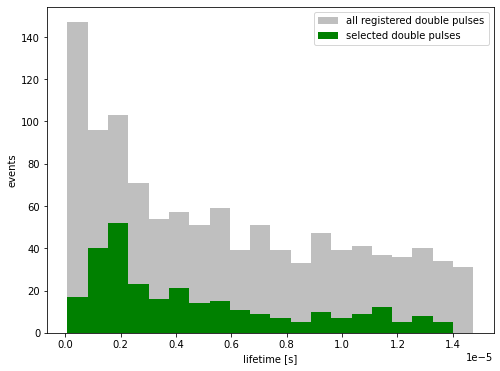

Number of double pulses:
	 All registered events: 1105
	 Selected events:       286


In [6]:
# > Choose a useful interval [dtmin, dtmax] for the decay times in µs

dtmin = 0.6e-6
dtmax = 14.0e-6

# > Define pdf for expontential decay

def exponentialDecayPDF(t, tau=2.2e-6, fbg=0.3, a=dtmin, b=dtmax): # code for pdf & fit is modified from G. Quast, see http://www-ekp.physik.uni-karlsruhe.de/~quast/jupyter/negLogLFits.ipynb
    """
    :param t: decay time
    :param tau: expected mean of the decay time
    :param fbg: background
    :param a: the minimum decay time which can be measured
    :param b: the maximum decay time which can be measured
    :return: probability for decay time t
    """
    pdf1 = np.exp(-t / tau) / tau / (np.exp(-a / tau) - np.exp(-b / tau))
    pdf2 = 1. / (b - a)
    return (1 - fbg) * pdf1 + fbg * pdf2

# > Read in data from measurement

measurements = ['lifetime/lifetime_2021-10-27_110021.csv','lifetime/lifetime_2021-10-27_113111.csv','lifetime/lifetime_2021-10-27_102733.csv']

data = pd.concat([pd.read_csv(i, sep="\t") for i in measurements])

# > Cut for copper decays

mask1 = (data['1st chA height'] > 70) & (data['1st chB height'] > 70) & (data['1st chC height'] == 0) & ((data['2nd chB height'] > 30) | (data['2nd chC height'] > 30)) # this is the typical signature of a muon decaying in copper
mask2 = (data['decay time (ns)'] * 1.0e-9 > dtmin) & (data['decay time (ns)'] * 1.0e-9 < dtmax) # apply the cut for the chosen time interval [dtmin, dtmax]

cut = data[mask1 & mask2] # apply the cut

# > Plot cut results

plt.subplots(figsize=(8,6))
plt.hist(data['decay time (ns)']* 1.0e-9,20,range=(min(data['decay time (ns)']* 1.0e-9),np.max(data['decay time (ns)']* 1.0e-9)),alpha=0.5,color='gray',label='all registered double pulses')
plt.hist(cut['decay time (ns)']* 1.0e-9,20,range=(min(data['decay time (ns)']* 1.0e-9),np.max(data['decay time (ns)']* 1.0e-9)),color='green',label='selected double pulses')
plt.xlabel('lifetime [s]')
plt.ylabel('events')
plt.legend()
plt.legend()
plt.show()

print('Number of double pulses:')
print("\t All registered events: %s" % (len(data)))
print("\t Selected events:       %s" % (len(cut)))

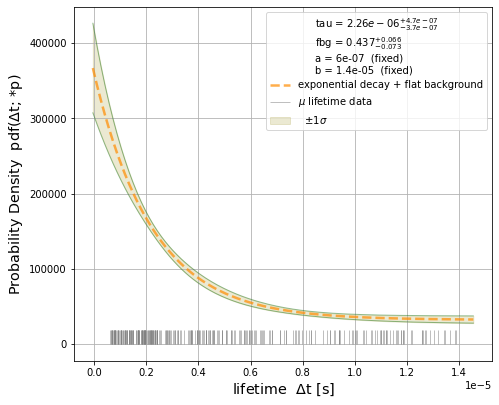

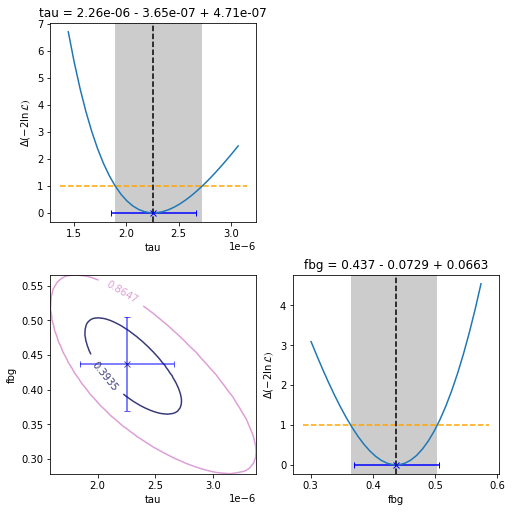


*==* unbinned ML Fit Result:
 parameter names:        ['tau' 'fbg' 'a' 'b']
 parameter values:       [2.25665140e-06 4.37336859e-01 6.00000000e-07 1.40000000e-05]
 neg. parameter errors:  [-3.65471967e-07 -7.29292866e-02]
 pos. parameter errors:  [4.71096609e-07 6.63482589e-02]
 correlations : 
 [[ 1.         -0.70222352]
 [-0.70222352  1.        ]]


In [7]:
# > Perform fit

dT = cut.to_numpy() # convert dataframe to numpy array for ease of use
dT = dT[:,2] # we only need the decay times
dT = dT * 1.0e-9 # convert ns to s

results = mFit(exponentialDecayPDF,
        data = dT,               # data - if not None, a normalised PDF is assumed as model
        limits=('fbg', 0., 1.),  # parameter limits
        fixPars = ['a', 'b'],    # fix parameter(s)
        neg2logL = True,         # use  -2 * ln(L)
        plot=True,               # plot data and model
        plot_band=True,          # plot model confidence-band
        plot_cor=True,           # plot profiles likelihood and contours
        axis_labels=['lifetime  ' + '$\Delta$t [s]',
                        'Probability Density  pdf($\Delta$t; *p)'],
        data_legend = '$\mu$ lifetime data',
        model_legend = 'exponential decay + flat background' )

# > Print results

pvals, perrs, cor, gof, pnams = results.values()
print('\n*==* unbinned ML Fit Result:')
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)

## $\textbf{1.6 Nachweis der Präzession des Myonenspins im Magnetfeld}$ <a class="anchor" id="chapter6"></a>

Im letzten Teil des Versuchs soll die Präzession des Myonenspins im Magnetfeld nachgewiesen werden. Dafür wird eine 7-tägige Lebensdauermessung mit eingeschaltetem Magnetfeld gestartet.
In der Versuchsvorbereitung wird gezeigt, dass die Anzahl der zum Zeitpunkt $t$ nachgewiesenen Positronen bei eingeschaltetem Magnetfeld gegeben ist durch:

$$
N(t) = K \cdot \textrm{e}^{-t/\tau} \cdot [1+\overline{A}\cdot \cos(\omega t + \delta)]
$$

Wieder unter der Annahme, dass die Messdaten einen konstanten Untergrund aufweisen, ist die normierte Wahrscheinlichkeitsdichte, die diesen modulierten Zerfall mit Untergrund beschreibt, gegeben durch:

$$
\textrm{modulatedDecayPDF}(t, \tau, f, \overline{A}, \delta, \omega, a, b) = (1-f) \cdot \frac{\textrm{e}^{-t/\tau} \cdot [1+\overline{A}\cdot \cos(\omega t + \delta)]}{I} + f \cdot \frac{1}{b-a}
$$

mit dem Normierungsfaktor

\begin{align}
I &= \int_a^b \textrm{e}^{-t/\tau} \cdot [1+\overline{A}\cdot \cos(\omega t + \delta)] \textrm{d} t\\
&= \left[\dfrac{\mathrm{e}^{-\frac{t}{{\tau}}}\left(\left({\omega}\sin\left({\omega}t+{\delta}\right){\tau}^2-\cos\left({\omega}t+{\delta}\right){\tau}\right){\overline{A}}-{\omega}^2{\tau}^3-{\tau}\right)}{{\omega}^2{\tau}^2+1}\right]_{t = a}^{t = b}
\end{align}

Dabei ist $a$ die untere und $b$ die obere Grenze für die registrierbaren Zerfallszeiten.

Diese Wahrscheinlichkeitsdichte soll mittels Histogrammfit an die Messdaten angepasst werden. Um die Oszillation geeignet auflösen zu können, ist eine hinreichend hohe Dichte der Bins zu wählen. Um die statistischen Fehler auf die einzelnen Bins gering zu halten, sollten allerdings auch nicht zu viele Bins verwendet werden.
Zwecks Anschaulichkeit werden die erwarteten Wahrscheinlichkeitsdichten geplottet. Mit Hilfe der Plots ist es möglich, eine geeignete Zahl an Bins abzuschätzen. Es werden die folgenden Konstanten angenommen:

* Die Lebensdauer des Myons wird auf den Literaturwert $\tau = 2.2$ µs gesetzt.

* Ein Untergrundanteil von $f = 30$% wird angenommen.

* Die Präzessionsmodulation wird auf $\overline{A} = 5$% gesetzt.

* Die Phasenverschiebung $\delta$ ist abhängig von der Zerfallskinematik und der Polarisation des zerfallenden Myons. Es gilt $\delta = \begin{cases} 0 & \textrm{oberer Detektor} \\ \pi & \textrm{unterer Detektor} \end{cases}$.

* Die theoretisch erwartete Oszillationskreisfrequenz ist nach der Versuchsvorbereitung gegeben durch $\omega_\textrm{lit} = \frac{g_\mu \cdot e \cdot B}{2m_\mu}$. Mit Hilfe der Literatur wird ein mittleres Magnetfeld von $B = 0.00412$ T bestimmt. Damit ergibt sich $\omega_\textrm{lit} \approx 3.51$ MHz.

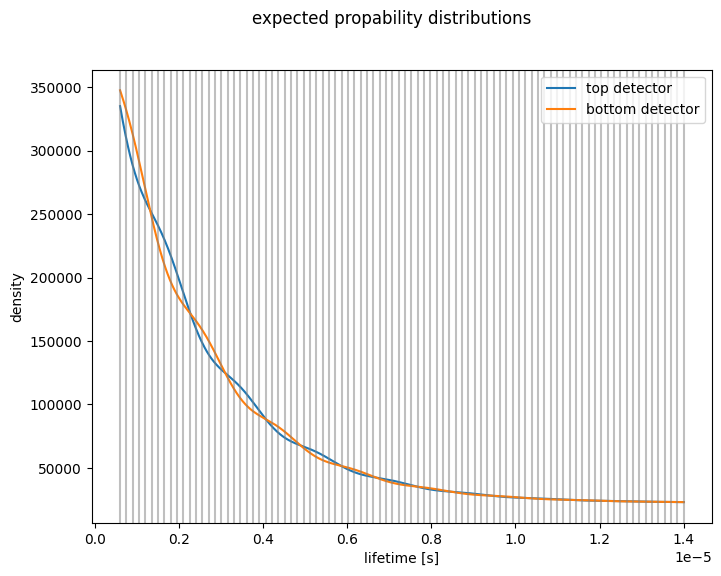

In [8]:
# > Calculate expected omega

g_lit = np.abs(const.physical_constants["muon g factor"][0])  #\
e = const.physical_constants["elementary charge"][0]          #|
m = const.physical_constants["muon mass"][0]                  #| code for this block is taken from lande_for_students.ipynb by C. Mayer
B = 0.00412  # magnetic field                                 #|
omega_lit = g_lit * e * B / (2 * m)                           #/

# > Choose a useful interval [dtmin, dtmax] for the decay times in s

dtmin = 0.6e-6
dtmax = 14.0e-6

# > Define pdf for modulated exponential decay

def modulatedDecayPDF(t, tau=2.2e-6, fbg=0.3, a_bar = 0.2, delta = 0., omega = omega_lit, a = dtmin, b = dtmax):
    """
    :param t: decay time
    :param tau: expected mean of the decay time
    :param fbg: background
    :param a_bar: modulation amplitude
    :param delta: phase shift
    :param omega: precession angular frequency
    :param a: the minimum decay time which can be measured
    :param b: the maximum decay time which can be measured
    :return: probability for decay time t
    """
    pdf1 = np.exp(-t / tau) * (1 + a_bar * np.cos(omega * t + delta)) / ((np.exp(-b / tau) * ((omega * np.sin(b * omega + delta) * tau**2 - np.cos(b * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau) - np.exp(-a / tau) * ((omega * np.sin(a * omega + delta) * tau**2 - np.cos(a * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau))  / (omega**2 * tau**2 + 1))
    pdf2 = 1. / (b - a)
    return (1 - fbg) * pdf1 + fbg * pdf2

# > Plot expected propability distributions

plt.subplots(figsize=(8,6), dpi = 100)
t = np.linspace(dtmin, dtmax, 1000)
lande_top = modulatedDecayPDF(t, tau=2.2e-6, fbg=0.30, a_bar = 0.05, delta = 0., omega = omega_lit, a = dtmin, b = dtmax)
lande_bottom = modulatedDecayPDF(t, tau=2.2e-6, fbg=0.30, a_bar = 0.05, delta = np.pi, omega = omega_lit, a = dtmin, b = dtmax)
non_modulated = modulatedDecayPDF(t, tau=2.2e-6, fbg=0.30, a_bar = 0, delta = 0, omega = omega_lit, a = dtmin, b = dtmax)
plt.plot(t,lande_top,label='top detector')
plt.plot(t,lande_bottom,label='bottom detector')
#plt.plot(t,non_modulated,linestyle='dashed',label='no modulation')
plt.xlabel('lifetime [s]')
plt.ylabel('density')
for x in np.linspace(dtmin, dtmax, 90):
    plt.axvline(x, color="gray", linestyle="-", alpha=0.5)
plt.legend()
plt.suptitle('expected propability distributions')
plt.show()

Es ist zu erkennen, dass eine Binszahl von ca. 90 ausreicht, um die Modulation geeignet aufzulösen. Mit den Kenntnissen der vorhergegangenen Versuchsteile werden nun erneut geeignete Schnitte am Datensatz vorgenommen.

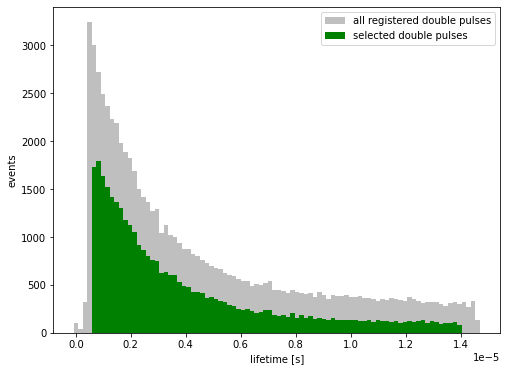

Number of double pulses:
	 All registered events: 67488
	 Selected events:       33224


In [9]:
# > Read in data from measurement

measurements = ['lande/lande_top_detector.txt']

data = pd.concat([pd.read_csv(i, sep="\t") for i in measurements])

# > Cut for useful decays

mask1 = (data['1st chA height'] > 70) & (data['1st chA height'] < 500) & (data['1st chB height'] > 70) & (data['2nd chB height'] > 70)
mask2 = (data['decay time (ns)'] * 1.0e-9 > dtmin) & (data['decay time (ns)'] * 1.0e-9 < dtmax) # apply the cut for the chosen time interval [dtmin, dtmax]

cut = data[mask1 & mask2] # apply the cut

# > Plot cut results

plt.subplots(figsize=(8,6))
plt.hist(data['decay time (ns)']* 1.0e-9,90,range=(min(data['decay time (ns)']* 1.0e-9),np.max(data['decay time (ns)']* 1.0e-9)),alpha=0.5,color='gray',label='all registered double pulses')
plt.hist(cut['decay time (ns)']* 1.0e-9,90,range=(min(data['decay time (ns)']* 1.0e-9),np.max(data['decay time (ns)']* 1.0e-9)),color='green',label='selected double pulses')
plt.xlabel('lifetime [s]')
plt.ylabel('events')
plt.legend()
plt.legend()
plt.show()

print('Number of double pulses:')
print("\t All registered events: %s" % (len(data)))
print("\t Selected events:       %s" % (len(cut)))

Das Modulationssignal ist im Experiment schwächer ausgeprägt, als in den Plots dargestellt. Es ist bereits bekannt, dass mit den Daten einer 7-tägigen Messung kein sicherer Fit mit 5 freien Parametern ($\tau, f, \overline{A}, \delta, \omega$) durchgeführt werden kann. 
Mit dem Likelihood-Ratio Test wird stattdessen ein einfacher Hypothesentest durchgeführt, in dessen Rahmen überprüft wird, wie stark sich die Messdaten von einem reinen exponentiellen Zerfall ohne Modulation unterscheiden. Dies erlaubt Rückschlüsse auf die Signifkanz der erwarteten Präzessionsmodulation.
Das Vorgehen lautet entsprechend wie folgt: Zunächst werden die Messdaten an einen reinen exponentiellen Zerfall mit Untergrund (Nullmodel) gefittet. Aus dem Fit ergeben sich Werte für die mittlere Lebensdauer $\tau$ und den Untergrundanteil $f$, welche in einem zweiten Fit an die modulierte Zerfallsfunktion (Alternativmodell) als fixe Parameter behandelt werden.
Es wird also explizit angenommen, dass auch der zweite Fit mit diesen Werten optimiert wird. Diese Annahme ist für die kleinen $\overline{A}$, die hier beobachtet werden, sehr gut erfüllt.
Weiterhin werden $\delta$ und $\omega$ auf die oben berechneten Werte gesetzt und im zweiten Fit ebenfalls festgehalten, sodass lediglich eine Optimierung der Oszillationsamplitude $\overline{A}$ stattfindet. Dabei wird $\overline{A}$ auf das physikalisch sinnvolle Intervall $[0,1]$ eingeschränkt, wobei eine Amplitude von 0 gerade dem Nullmodel entspricht.

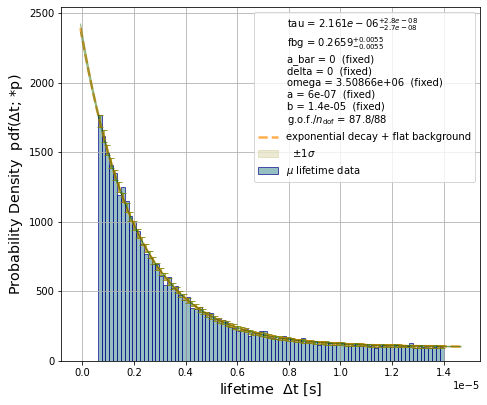

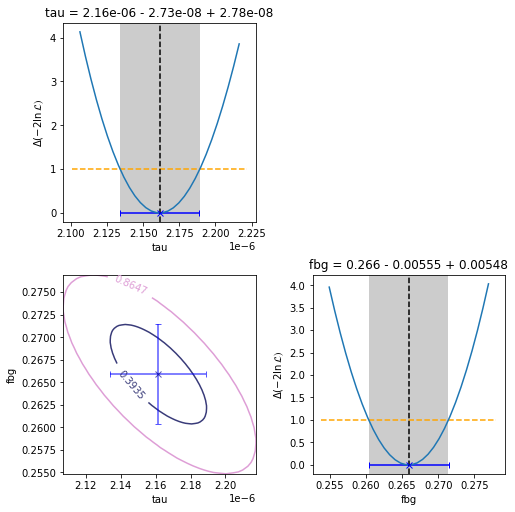


*==* unbinned ML Fit Result:
 parameter names:        ['tau' 'fbg' 'a_bar' 'delta' 'omega' 'a' 'b']
 parameter values:       [2.16133479e-06 2.65926991e-01 0.00000000e+00 0.00000000e+00
 3.50865568e+06 6.00000000e-07 1.40000000e-05]
 neg. parameter errors:  [-2.72663261e-08 -5.54733111e-03]
 pos. parameter errors:  [2.78388012e-08 5.47591676e-03]
 correlations : 
 [[ 1.         -0.69004084]
 [-0.69004084  1.        ]]


In [10]:
# > Perform fit without modulation

dT = cut.to_numpy() # convert dataframe to numpy array for ease of use
dT = dT[:,2] # we only need the decay times
dT = dT * 1.0e-9 # convert ns to s

bin_contents, bin_edges =  np.histogram(dT, 90)
results1 = hFit(modulatedDecayPDF,
       bin_contents, bin_edges,
       p0 = [2.2e-6, 0.3, 0., 0., omega_lit, dtmin, dtmax], # initial guess of parameters
       limits= ('fbg', 0., 1.),   # parameter limits
       fixPars = ['a_bar','delta','omega','a', 'b'],      # fix parameter(s)
       plot=True,                 # plot data and model
       plot_band=True,            # plot model confidence-band
       plot_cor=True,             # plot profile likelihood and contours
       #plot_residual=True,        # plot residual
       axis_labels=['lifetime  ' + '$\Delta$t [s]',
                       'Probability Density  pdf($\Delta$t; *p)'],
       data_legend = '$\mu$ lifetime data',
       model_legend = 'exponential decay + flat background' )

# > Print results

pvals1, perrs1, cor1, gof1, pnams1 = results1.values()
print('\n*==* unbinned ML Fit Result:')
print(" parameter names:       ", pnams1)
print(" parameter values:      ", pvals1)
print(" neg. parameter errors: ", perrs1[:,0])
print(" pos. parameter errors: ", perrs1[:,1])
print(" correlations : \n", cor1)

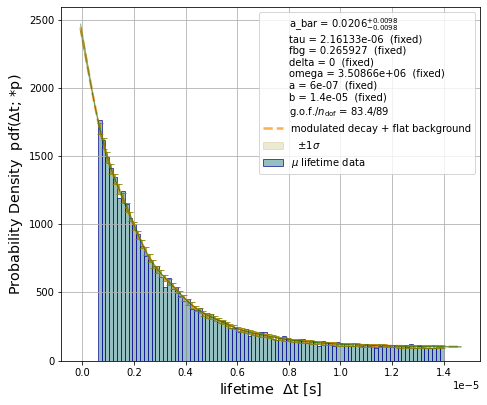

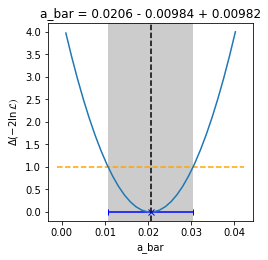


*==* unbinned ML Fit Result:
 parameter names:        ['a_bar' 'tau' 'fbg' 'delta' 'omega' 'a' 'b']
 parameter values:       [2.05794175e-02 2.16133479e-06 2.65926991e-01 0.00000000e+00
 3.50865568e+06 6.00000000e-07 1.40000000e-05]
 neg. parameter errors:  [-0.00984311]
 pos. parameter errors:  [0.009825]
 correlations : 
 [[1.]]


In [11]:
# > Get parameters from previous fit

tau_fit = pvals1[0]
fbg_fit = pvals1[1]

# > Perform fit with modulation

results2 = hFit(modulatedDecayPDF,
       bin_contents, bin_edges,
       p0 = [tau_fit, fbg_fit, 0.2, 0., omega_lit, dtmin, dtmax], # initial guess of parameters
       limits= ('a_bar', 0., 1.),   # parameter limits
       fixPars = ['tau','fbg','delta','omega','a','b'], # fix parameter(s)
       plot=True,                   # plot data and model
       plot_band=True,              # plot model confidence-band
       plot_cor=True,               # plot profile likelihood and contours
       #plot_residual=True,          # plot residual
       axis_labels=['lifetime  ' + '$\Delta$t [s]',
                       'Probability Density  pdf($\Delta$t; *p)'],
       data_legend = '$\mu$ lifetime data',
       model_legend = 'modulated decay + flat background' )

# > Print results

pvals2, perrs2, cor2, gof2, pnams2 = results2.values()
print('\n*==* unbinned ML Fit Result:')
print(" parameter names:       ", pnams2)
print(" parameter values:      ", pvals2)
print(" neg. parameter errors: ", perrs2[:,0])
print(" pos. parameter errors: ", perrs2[:,1])
print(" correlations : \n", cor2)

Nachdem die beiden Fits durchgeführt worden sind, kann die Teststatistik gebildet werden. Die Log-Likelihood-Ratio Teststatistik ist gegeben durch die Differenz der Log-Likelihoods vom Alternativ- und vom Nullmodel

\begin{align}
\Delta &= -2 \cdot \left[ \log\left(\mathcal{L}\left(\vec{t},\vec{p}_0\right)\right) - \log\left(\mathcal{L}\left(\vec{t},\vec{p}\right)\right)\right]\\
&= -2 \cdot \left[ \log\left(\prod_{i=1}^{n}\mathcal{L}\left(t_i,\vec{p}_0\right)\right) - \log\left(\prod_{i =1}^{n}\mathcal{L}\left(t_i,\vec{p}\right)\right)\right]\\
&= -2 \cdot \left[ \sum_{i=1}^{n}  \log\left(\mathcal{L}(t_i, \tau, f, \overline{A} = 0, \delta, \omega, a, b) \right) - \log\left(\mathcal{L}(t_i, \tau, f, \overline{A}, \delta, \omega, a, b) \right) \right]
\end{align}

mit den gemessenen Zerfallszeiten $t_i$.

Das Wilkssche Theorem besagt nun, dass unter Annahme eines wahren Nullmodells die Wahrscheinlichkeitsdichte der Teststatistik $\Delta$ sich im Grenzwert unendlich vieler Messwerte ($n \to \infty$) asymptotisch einer $\chi^2$-Verteilung annähert. Die Anzahl der Freiheitsgrade der $\chi^2$-Verteilung ist gegeben durch die Differenz der Zahl der Parameter von beiden Modellen. Im hier betrachteten Fall ist die Differenz eins, da im zweiten Fit zusätzlich noch $\overline{A}$ optimiert wird.
Um nun Herauszufinden, ob das Alternativmodell dem Nullmodell zu bevorzugen ist, muss $P(X \geq \Delta)$ berechnet werden. Dies ist der sogenannte $p$-Wert und er entspricht gerade der Wahrscheinlichkeit dafür, dass die Teststatistik einen Wert größer gleich $\Delta$ unter Annahme eines wahren Nullmodels annimmt. Ein niedriger $p$-Wert bedeutet also eine hohe Signifikanz für die Existenz der Modulation. Der $p$-Wert berechnet sich wie folgt:

$$
p = 1 - \int_{0}^{\Delta} {\chi_k ^{2}(x)} \ \textrm{d}x
$$

Dabei ist ${\chi_k ^{2}}$ die Chi-Quadrat Distribution mit $k$ Freiheitsgraden.

Dem $p$-Wert entspricht wiederum ein $z$-score. Der $z$-score gibt die Anzahl an Standardabweichungen $\sigma$ an, mit der eine gaußverteile Zufallsgröße von seinem Erwartungswert $\mu$ abweicht.

Eine sehr gute Approximation vom $z$-score ist für den Fall $k = 1$ gegeben über die Wurzel der Teststatistik $\Delta$:

$$
z\textrm{-score} = \sqrt{\Delta}
$$

Im Rahmen des Praktikums wird diese Näherung verwendet, da diese keine Kenntnisse über Wilks' Theorem voraussetzt.
Es ergibt sich $p = 1.43$% und damit ein $z$-score von $2.19$. Dieser Wert liefert also bereits einen deutlichen Hinweis auf die Präzession des Myonenspins, ist allerdings noch weit von der in der Teilchenphysik üblicherweise geforderten Signifikanz von $5 \sigma$ entfernt. Es ist davon auszugehen, dass die Signifikanz z.B. durch längere Messzeiten deutlich verbessert werden kann.

In [12]:
# > Get optimal values from previous fit

a_bar = pvals2[0]
tau = pvals2[1]
fbg = pvals2[2]
delta = pvals2[3]
omega = pvals2[4]
a = pvals2[5]
b = pvals2[6]

# > Calculate the Log-Likelihoods

non_modulated_probabilities = modulatedDecayPDF(dT, tau, fbg, 0, delta, omega, a, b)
modulated_probabilities = modulatedDecayPDF(dT, tau, fbg, a_bar, delta, omega, a, b)
non_modulated_log_likelihood = np.sum(np.log(non_modulated_probabilities))
modulated_log_likelihood = np.sum(np.log(modulated_probabilities))

# > Calculate the negative log likelihood ratio of the two models and the corresponding z-score

Delta = -2*(non_modulated_log_likelihood - modulated_log_likelihood)
z = np.sqrt(Delta)
p = 1 - st.norm.cdf(z)

# > Alternatively use Wilks' Theorem to calculate the z-score

#p = 1 - st.chi2.cdf(Delta, 1)
#z = st.norm.ppf(1 - p)

# > Print results

print("Results of the Likelihood-Ratio test:")
print("\t NlL non-modulated: %s"   % ("{:.2f}".format(-non_modulated_log_likelihood)))
print("\t NlL modulated:     %s"   % ("{:.2f}".format(-modulated_log_likelihood)))
print("\t Delta:             %s"   % ("{:.3f}".format(Delta)))
print("\t z-score:           %s"   % ("{:.2f}".format(z)))
print("\t p:                 %s%s" % ("{:.2f}".format(p*100),'%'))

Results of the Likelihood-Ratio test:
	 NlL non-modulated: -387293.14
	 NlL modulated:     -387295.54
	 Delta:             4.796
	 z-score:           2.19
	 p:                 1.43%
